# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

This is a classification problem because we expect the system to categorize the students into those in need of intervention of not. Classification uses class labels as its input.

Regression on the other hand would take in continous values to make a prediction - e.g. grade predictions.

As noted by my reviewer "there's good evidence student interventions actually work (http://www.wsj.com/articles/a-small-fix-in-mind-set-can-keep-students-in-school-1466095795)"

Further supporting evidence for fostering a growth as opposed to a fixed intelligence mindset, in addition to fostering "grit", can be found extensively in academia. Angela Duckworth's body of work if a great place to start, either way, in addition to useful domain knowledge this only serves to emphases how important this solving this problem could potentially be.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [13]:
# Import libraries
import numpy as np
import pandas as pd
from time import time  
from sklearn.metrics import f1_score


# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


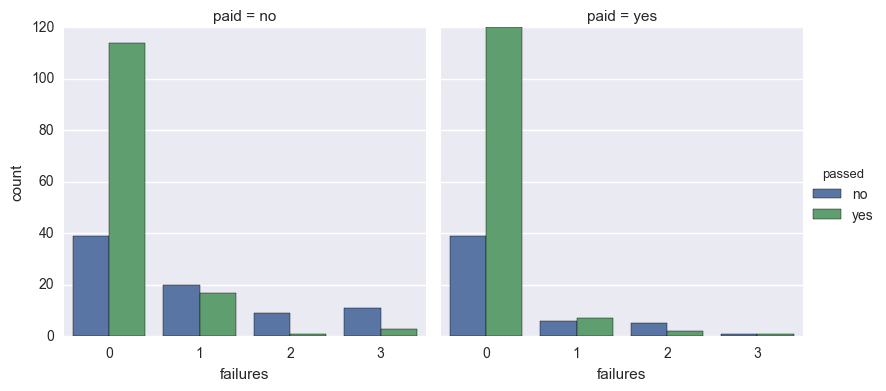

In [14]:
# Done: Calculate number of students

# print student_data.describe()

n_students = student_data.shape[0]
# print n_students

# Done: Calculate number of features
n_features = student_data.shape[1]

# Eliminate what we want to predict (note a feauture)
# print n_features

n_features = n_features - 1




# DONE: Calculate passing students

# Get all passed students in dataframe
n_passed = student_data[student_data['passed']=='yes']

#AEEFAE
n_passed = n_passed.shape[0]





# DONE: Calculate failing students
# as code above except all in one line:

n_failed = student_data[student_data['passed']=='no'].shape[0]

# DONE: Calculate graduation rate
# (passed students / total students ) * 100

# Note to self : Python 2 Hell requires float for division below to work
#next time import division from future

grad_rate = (float(n_passed)/float(n_students)) * 100
# grad_rate = grad_rate * 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

#Expanded exploratory analysis with addition of visualization
%matplotlib inline
import seaborn as sns
sns.factorplot("failures", col="paid", data=student_data, hue='passed', kind="count");

In [15]:
from sklearn.metrics import f1_score
print "\nF1 score for predicting all 'yes': {:.4f}".format(
    f1_score(y_true = ['yes']*n_passed + ['no']*n_failed, y_pred = ['yes']*n_students, pos_label='yes', average='binary'))


F1 score for predicting all 'yes': 0.8030


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [16]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [17]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [18]:
# DONE: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html


# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# DONE: Shuffle and split the dataset into the number of training and testing points above
# code given replaced with 1 linner developed in Project 1
# note watch out for test_size!
# Stratify parameter added to maintain class differences
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, stratify=y_all, random_state=9)

# X_train = None
# X_test = None
# y_train = None
# y_test = None

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

#confirm class imbalance
print "Grad rate of train set: {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Grad rate of test set: {:.2f}%".format(100 * (y_test == 'yes').mean())


Training set has 300 samples.
Testing set has 95 samples.
Grad rate of train set: 67.00%
Grad rate of test set: 67.37%


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

| Model          | Application                                                                                                                                                                                          | Strengths                                                                                                                                                                                                                                                       | Weaknesses                                                                                                                                                                                                                                                                                                                          | What makes it appropriate                                                                       |
|----------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------|
| Decision Trees | Game Theory (great to model games like prisoners dilemma), more practically Watson uses this (amongst other techniques) to diagnose medical issues (https://www.ibm.com/watson/watson-oncology.html) | Accurate (the tree stops somewhere), this also makes it somewhat resistant to noisy and missing data (I'm borrowing from a different field but if an end node doesn't fit some test - nash equilibrium e.g. - you can climb up the tree and try the next node). | It suffers when strategies (is this the right terminology  to use in ML?) are duplicated in multiple subgames. Complexity is the enemy of decision trees, the N-XOR example given in class is a prime example.                                                                                                                      | Weighted feauture coloumns should make the intervention system easy to                          |
| KNN            | Facebook and other social media platforms probably use this to learn more about people they have little information about. https://research.facebook.com/publications/reciprocal-hash-tables-for-nearest-neighbor-search/                                                                          | It's extremely flexible and can be used for classification and regression. It is simple and stores all the data it needs. No training and very little tunning needed.                                                                                                                                      | I think it could be costly to implement - one would need to be smoothed out to account for crazy outliers (e.g. target x is friends with the worlds tallest and shortest person.) so K-Means would be better                                                                                                                        | It is easy to conceptualize. Put on a graph it's intuitive to zero in on the target variables   |
| Naive Bayes    | Amazon uses this to recommend products a user might like.                                                                                                                                            | Simple and fast with alright performance                                                                                                                                                                                                                        | It's excellent and inferring positive associations but will miss out on variables which may negate the conclusion. E.g. Most students in need of help have at least one E grade, but Jill an otherwise straight A student hates Gym and gets an E. Does she need an intervention? Depending on how this model is put together, yes. | With the right variables (e.g. total GPA) it's by far the simplest to implement and understand. |

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [19]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [20]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB


# TODO: Initialize the three models
clf = DecisionTreeClassifier(random_state=0)
clf_B = GaussianNB()
clf_C = KNeighborsClassifier()


# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
train_predict(clf, X_train_100, y_train_100, X_test, y_test)
train_predict(clf, X_train_200, y_train_200, X_test, y_test)
train_predict(clf, X_train_300, y_train_300, X_test, y_test)

train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)

train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0224 seconds
Made predictions in 0.0030 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0034 seconds.
F1 score for test set: 0.6555.
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0034 seconds
Made predictions in 0.0012 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0007 seconds.
F1 score for test set: 0.7939.
Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0140 seconds
Made predictions in 0.0007 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0005 seconds.
F1 score for test set: 0.7619.
Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0021 seconds
Made predictions in 0.0012 seconds.
F1 score for training set: 0.7863.
Made predictions in 0.0015 seconds.
F1 score for test set: 0.5893.
Training a GaussianNB using a training set s

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - DecisionTreeClassifier 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
|:-----------------:|:-------------:|:----------------------:|:----------------:|:---------------:|
|        100        |     0.0235    |         0.0014         |      1.0000      |      0.7556     |
|        200        |     0.0021    |         0.0006         |      1.0000      |      0.7385     |
|        300        |     0.0036    |         0.0005         |      1.0000      |      0.7442     |



** Classifer 2 - KNeighborsClassifier
  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
|:-----------------:|:-------------:|:----------------------:|:----------------:|:---------------:|
|        100        |     0.0009    |         0.0028         |      0.8667      |      0.8235     |
|        200        |     0.0010    |         0.0071         |      0.8256      |      0.8056     |
|        300        |     0.0015    |         0.0091         |      0.8710      |      0.8108     |


** Classifer 3 - Naive Bayes GaussianNB
  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
|:-----------------:|:-------------:|:----------------------:|:----------------:|:---------------:|
|        100        |     0.0011    |         0.0005         |      0.2857      |      0.2588     |
|        200        |     0.0012    |         0.0005         |      0.7559      |      0.7910     |
|        300        |     0.0013    |         0.0006         |      0.7931      |      0.8429     |




## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

I have chosen  the Naive Bayes model  is the best model to use on the student data. As evidenced by the increasing F1 score, this model is particularly effective when given a large set of training data. Compared to the decision tree and naive base models the F1 squaw increased significantly while training time skilled linearly. As a form of instance based learning computation costs is certainly costlier than the other models however, the trade-off is justifiable given the business progress and the high accuracy it is able to achieve.

That being said, when compared to a benchmark model which predicts all yes values on the test set the results of which are shown in the block below (0.8050) we can assume that more work should be done to make the model more accurate.



In [21]:
from sklearn.metrics import f1_score
print "F1 score for predicting all \"yes\" on test set: {:.4f}".format(
    f1_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))

F1 score for predicting all "yes" on test set: 0.8050


### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

The Naive Bayes classifier like most machine learning classifiers must be trained. We do this by splitting the data, in this case the students, into training and testing pairs. The training set as the name implies is where we apply our algorithm, we then use data the algorithm has never seen, the testing set, to confirm that our algorithm works.

This particular algorithm, the naive bayes classifer, works by asking what are the chances of an event happening (for example a student passing) given that another event has occured (e.g. perfect attendence). It's "naive" because the algorithm is not given information about the past, each time we ask it, it's as if it's for the veyr first time.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [24]:
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import make_scorer
# TODO: Import 'GridSearchCV' and 'make_scorer'

# TODO: Create the parameters list you wish to tune
# parameters = {'absences' : [50,150]}
parameters =  {'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}


# Previous parameters did not result in an increase in F1 score. Third times the charm
# Nope! parameter 2's better
# parameters = {'n_neighbors':[2,4,8,16,32], 
#               'weights':["uniform", "distance"],
#               'p':[2,3]
#              }
#  : {}

# TODO: Initialize the classifier
clf = clf_C

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0053 seconds.
Tuned model has a training F1 score of 0.8773.
Made predictions in 0.0020 seconds.
Tuned model has a testing F1 score of 0.7883.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

The F1 score for training is 0.8664 and for testing is 0.8027, they are reasonably close enough together to reassure our choice of the model.

In [25]:
from IPython.display import display
display(pd.DataFrame(grid_obj.grid_scores_))

,parameters,mean_validation_score,cv_validation_scores
0,{u'algorithm': u'auto'},0.780307,"[0.776315789474, 0.783783783784, 0.780821917808]"
1,{u'algorithm': u'ball_tree'},0.783091,"[0.76821192053, 0.789115646259, 0.791946308725]"
2,{u'algorithm': u'kd_tree'},0.780307,"[0.776315789474, 0.783783783784, 0.780821917808]"
3,{u'algorithm': u'brute'},0.793037,"[0.779220779221, 0.794520547945, 0.805369127517]"


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.